<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ARIMA Model


## Imports


In [79]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
# import arima model
from statsmodels.tsa.arima.model import ARIMA

## Utilities


In [80]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Load and Preview the Dataset


In [81]:
paris_df = pd.read_csv('./data/metropoles_consumption/eco2mix-Paris.csv', sep=';')
paris_df.head()

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
0,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,21:15,2023-09-05T21:15:00+02:00,3618.0,ND,3598
1,200054781,Métropole du Grand Paris,Données temps réel,2023-09-05,23:30,2023-09-05T23:30:00+02:00,3278.0,ND,3262
2,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:00,2023-09-06T00:00:00+02:00,3034.0,ND,3018
3,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:15,2023-09-06T00:15:00+02:00,2941.0,ND,2921
4,200054781,Métropole du Grand Paris,Données temps réel,2023-09-06,00:30,2023-09-06T00:30:00+02:00,2877.0,ND,2857


In [82]:
# order the dataframe by increasing date, then hour
paris_df = paris_df.sort_values(by=['Date', 'Heures'])
paris_df.head(5)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
227349,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:15,2017-02-13T01:15:00+01:00,4917.0,NaN,NaN
103575,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:30,2017-02-13T01:30:00+01:00,4774.0,NaN,NaN
194843,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:45,2017-02-13T01:45:00+01:00,4716.0,NaN,NaN
194844,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:00,2017-02-13T02:00:00+01:00,4660.0,NaN,NaN
227350,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:15,2017-02-13T02:15:00+01:00,4695.0,NaN,NaN


In [83]:
# see the number of rows where consumption = 0
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

# replace rows where consumption = 0 with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption = 0
zero_consumption_indices = paris_df[paris_df['Consommation (MW)'] == 0].index

# loop over the indices
for index in zero_consumption_indices:

  # get the mean of the 3 previous and 3 next values
  mean_consumption = paris_df.loc[index-3:index+3, 'Consommation (MW)'].mean()

  # replace the value with the mean
  paris_df.loc[index, 'Consommation (MW)'] = mean_consumption
print('Number of rows with consumption data = 0: ', len(paris_df[paris_df['Consommation (MW)'] == 0]))

Number of rows with consumption data = 0:  120
Number of rows with consumption data = 0:  0


In [84]:
# display nan values
paris_df.isna().sum()



Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)       3003
Production            179707
Echanges physiques    179707
dtype: int64

In [85]:
paris_df.head(50)

,Code métropole,Métropole,Nature,Date,Heures,Date - Heure,Consommation (MW),Production,Echanges physiques
227349,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:15,2017-02-13T01:15:00+01:00,4917.0,NaN,NaN
103575,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:30,2017-02-13T01:30:00+01:00,4774.0,NaN,NaN
194843,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,01:45,2017-02-13T01:45:00+01:00,4716.0,NaN,NaN
194844,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:00,2017-02-13T02:00:00+01:00,4660.0,NaN,NaN
227350,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:15,2017-02-13T02:15:00+01:00,4695.0,NaN,NaN
103576,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:30,2017-02-13T02:30:00+01:00,4625.0,NaN,NaN
103577,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,02:45,2017-02-13T02:45:00+01:00,4571.0,NaN,NaN
16687,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,03:00,2017-02-13T03:00:00+01:00,4532.0,NaN,NaN
227351,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,03:15,2017-02-13T03:15:00+01:00,4524.0,NaN,NaN
55572,200054781,Métropole du Grand Paris,Données temps réel,2017-02-13,03:30,2017-02-13T03:30:00+01:00,4489.0,NaN,NaN


In [86]:
# replace rows where consumption = na with the mean of the 3 previous and 3 next values

# get the indices of the rows where consumption is na
na_consumption_indices = paris_df[paris_df['Consommation (MW)'].isna()].index

# loop over the indices
for index in na_consumption_indices:

  # get the mean of the 5 previous and 5 next values
  mean_consumption = paris_df.loc[index-2:index+2, 'Consommation (MW)'].mean()

  # replace the value with the mean
  paris_df.loc[index, 'Consommation (MW)'] = mean_consumption

# drop the rows where 'consumption' is still na
paris_df = paris_df.dropna(subset=['Consommation (MW)'])
# display nan values
paris_df.isna().sum()

Code métropole             0
Métropole                  0
Nature                     0
Date                       0
Heures                     0
Date - Heure               0
Consommation (MW)          0
Production            179705
Echanges physiques    179705
dtype: int64

In [87]:
# get time series of consumption
paris_consumption = paris_df['Consommation (MW)']

# get accompanying timesteps (date+hour converted to datetime)
paris_time = pd.to_datetime(paris_df['Date'] + ' ' + paris_df['Heures'], format='%Y-%m-%d %H:%M')


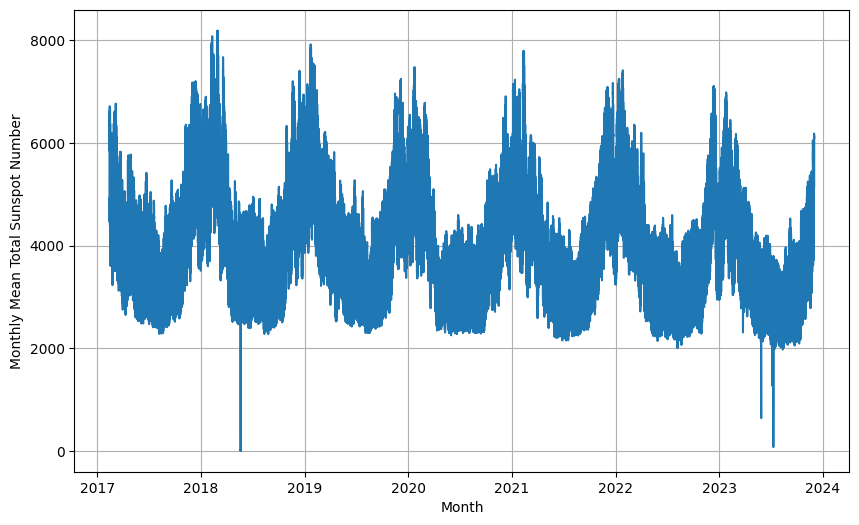

In [88]:

# Convert lists to numpy arrays
time = np.array(paris_time)
series = np.array(paris_consumption)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

In [89]:
# print datatype of time
print('Time datatype: ', time.dtype)

# print datatype of series
print('Series datatype: ', series.dtype)

Time datatype:  datetime64[ns]
Series datatype:  float64


In [90]:
# convert datetime to timesteps (integer values)
time = np.array(range(len(paris_time)))

# print data type
print('Data type of series:', series.dtype)

# print data type
print('Data type of time:', time.dtype)


Data type of series: float64
Data type of time: int32


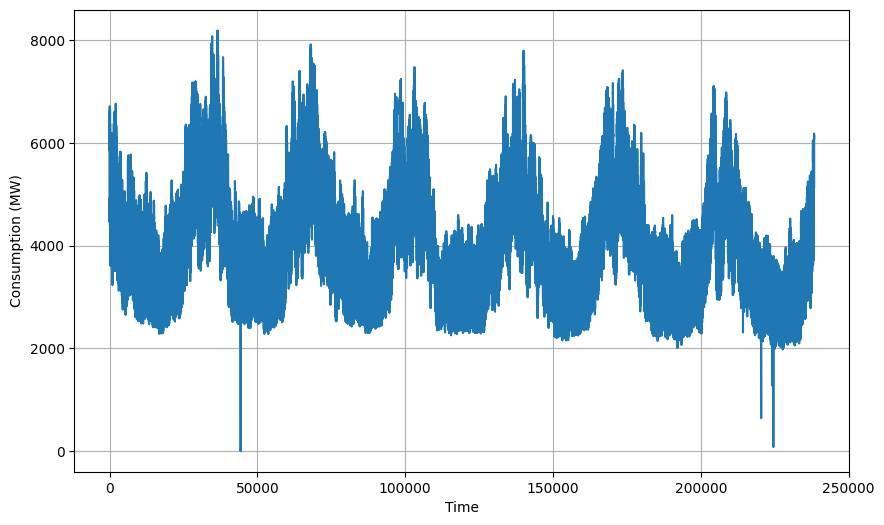

In [91]:
# plot the time series
plot_series(time, series, xlabel='Time', ylabel='Consumption (MW)')

In [92]:
# do auto arima
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())



KeyboardInterrupt: 

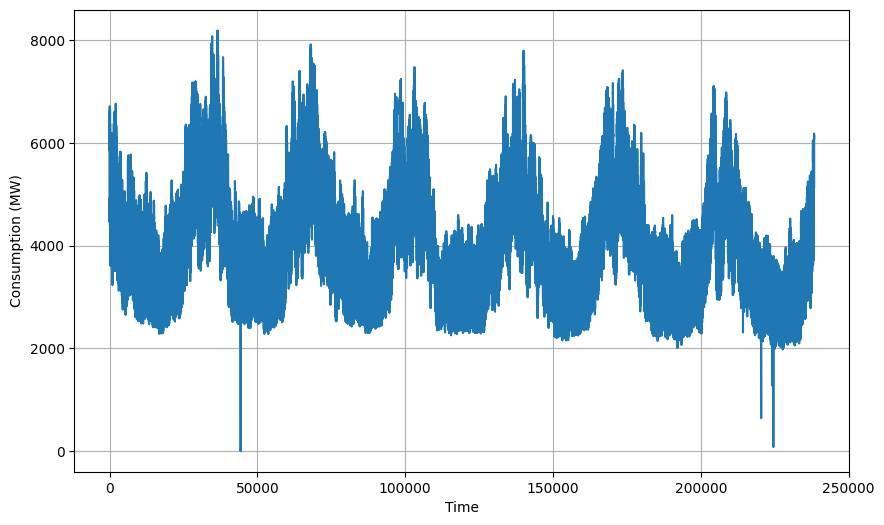

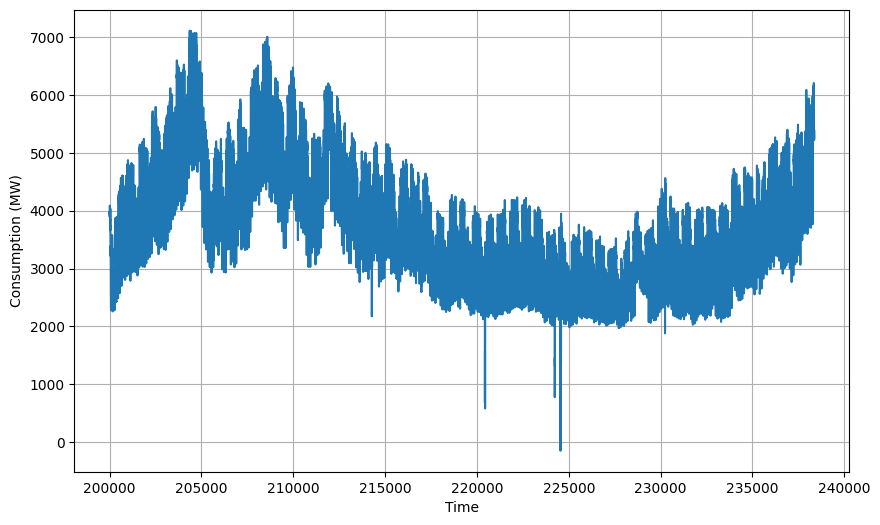

In [ ]:

# get predictions
predictions = model_fit.predict(start=200000, end=len(series)-1)

# plot predictions
plot_series(time, series, xlabel='Time', ylabel='Consumption (MW)')

# predictions starts at 200000 and ends at len(series)
plot_series(time[200000:len(series)], predictions, xlabel='Time', ylabel='Consumption (MW)')


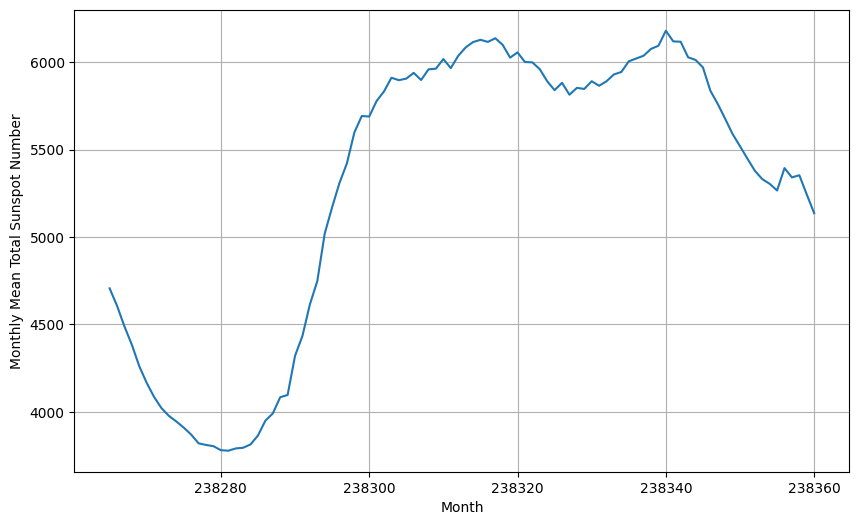

In [ ]:
plot_series(time[-24*4:], series[-24*4:], xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

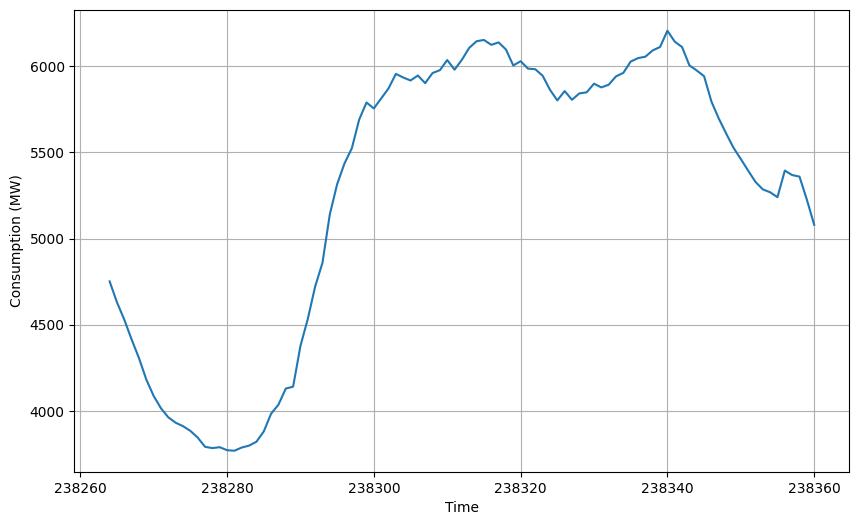

In [ ]:
# get the next 24 hours of predictions (time step of the data is 15 minutes)
predictions = model_fit.predict(start=len(series)-24*4, end=len(series))
predictions_time = np.array(range(len(series)-24*4-1, len(series)))

# plot predictions
plot_series(predictions_time, predictions, xlabel='Time', ylabel='Consumption (MW)')



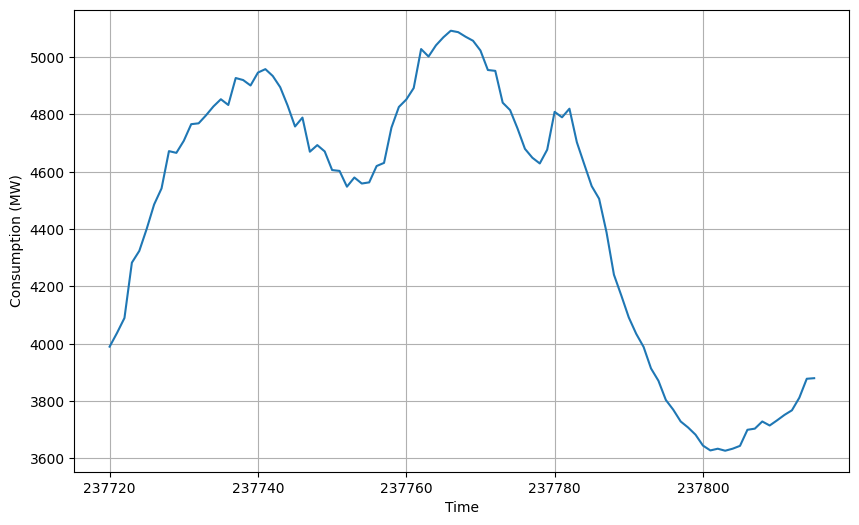

96

In [ ]:
# plot the last 24hours of the series
day = 238200 - 5*24*4 
plot_series(time[day:day+24*4], series[day:day+24*4], xlabel='Time', ylabel='Consumption (MW)')
len(time[day:day+24*4])
